# Imports + CUDA

In [1]:
import torch
import matplotlib.pyplot as plt
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name()) 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

2.6.0+cu124
12.4
True
NVIDIA GeForce RTX 3070 Laptop GPU
Training on cuda


In [ ]:
def show_digit_reconstructions(y: int | str | None, X: torch.Tensor, y_labels: torch.Tensor, model: torch.nn.Module, device: torch.device, n_samples: int = 10):
    """
    Affiche n_samples images du chiffre y, leurs reconstructions et codes latents.
    
    Args:
        y: chiffre à afficher (0-9), 'random' ou None pour des chiffres aléatoires
        X: dataset complet
        y_labels: labels correspondants (y_train ou y_test)
        model: modèle entraîné (MLPAutoencoder ou KANAutoencoder)
        device: device pour les calculs
        n_samples: nombre d'exemples à afficher
    """
    if y is None or y == 'random':
        # S'assurer qu'on ne demande pas plus d'échantillons que disponibles
        n_samples = min(n_samples, len(X))
        selected_indices = torch.randperm(len(X))[:n_samples]
        title = 'Original (random digits)'
    else:
        digit_indices = (y_labels == y).nonzero().squeeze()
        # S'assurer qu'on ne demande pas plus d'échantillons que disponibles pour ce chiffre
        n_samples = min(n_samples, len(digit_indices))
        if len(digit_indices) == 0:
            raise ValueError(f"Aucun exemple trouvé pour le chiffre {y}")
        selected_indices = digit_indices[torch.randperm(len(digit_indices))[:n_samples]]
        title = f'Original (digit {y})'
    
    samples = X[selected_indices]
    
    # Obtenir reconstructions
    model.eval()
    with torch.no_grad():
        # Handle both MLPAutoencoder and KANAutoencoder
        if hasattr(model, 'reconstruct'):
            reconstructions = model.reconstruct(samples.to(device))
            _, latent_codes = model(samples.to(device))
        else:
            reconstructions, latent_codes = model(samples.to(device))
        
        # Déplacer les tenseurs sur CPU avant conversion numpy
        samples = samples.cpu()
        reconstructions = reconstructions.cpu()
        latent_codes = latent_codes.cpu()
    
    # Afficher images originales et reconstructions
    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        # Image originale
        plt.subplot(2, n_samples, i+1)
        plt.imshow(samples[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title(title)
        
        # Image reconstruite
        plt.subplot(2, n_samples, n_samples+i+1)
        plt.imshow(reconstructions[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Reconstruction')
    
    plt.tight_layout()
    plt.show()
    
    # Afficher codes latents
    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        plt.bar(range(latent_codes.size(1)), latent_codes[i])
        plt.title(f'Code #{i+1}')
        plt.ylim(-3, 3)
        if i == 0:
            plt.ylabel('Value')
        plt.xlabel('Dimension')
    
    plt.tight_layout()
    plt.show()
    
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(121)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot training metrics if available
    if 'train_metrics' in history and 'val_metrics' in history:
        plt.subplot(122)
        plt.plot(history['train_metrics'], label='Training Metric')
        plt.plot(history['val_metrics'], label='Validation Metric')
        plt.title('Model Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Metric')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    
    
def get_mean_latent_factors(digit, X, y, model, device):
    """
    Calcule la moyenne des facteurs latents pour un chiffre donné
    
    Args:
        digit (int): Le chiffre dont on veut la moyenne des facteurs latents (0-9)
        X (torch.Tensor): Dataset MNIST complet
        model: Le modèle d'autoencoder
        device: Device sur lequel faire les calculs (cpu/cuda)
    
    Returns:
        torch.Tensor: Vecteur moyen des facteurs latents pour le chiffre
    """
    # Convertir y en tensor PyTorch
    y_tensor = torch.tensor(y, dtype=torch.long)
    
    # Récupérer les indices des '7' dans le dataset
    digit_indices = torch.where(y_tensor == digit)[0]
    
    # Extraire les images correspondantes
    digit_images = X[digit_indices].to(device)
    
    # Passer dans l'encodeur pour obtenir les facteurs latents
    with torch.no_grad():
        latent_factors = model.encode(digit_images)
    
    # Calculer la moyenne sur tous les exemples
    mean_factors = torch.mean(latent_factors, dim=0)
    
    return mean_factors


In [ ]:
from time import sleep

allocated = torch.cuda.memory_allocated()
reserved = torch.cuda.memory_reserved()

torch.cuda.empty_cache()
sleep(1)

print(f"{torch.cuda.memory_allocated()/1024**2:.2f} MB allocated")

0.00 MB allocated


# Load MNIST dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.models.ae_kan import KANAutoencoder

train = pd.read_csv("data/MNIST/csv/mnist_train.csv")
test = pd.read_csv("data/MNIST/csv/mnist_test.csv")
print(train.shape, test.shape)

(60000, 785) (10000, 785)


In [5]:
# Préparation des données
y_train = train['label'].values

X = torch.tensor(
    train.drop('label', axis=1).values / 255.0,
    dtype=torch.float32
)   #ne plus mettre sur GPU car je le charge batch par batch ensuite avec DataLoader

print(X.shape)

torch.Size([60000, 784])


# KAN autoencoder

In [7]:
input_dim = 784  # 28x28 pixels
latent_dim = 16

model = KANAutoencoder(
    input_dim=input_dim,
    k=latent_dim,
    hidden_dims=[256, 128],
    basis_type="spline",
    M=16,  # pour les splines sur la grille
    poly_degree=3,
    dropout_p=0,
    use_silu=True,
    
    
    
    # Loss
    loss_type="huber",
    huber_delta=1.0,
    
    # Régularisations
    lambda_alpha=1e-4,
    lambda_group=1e-5,
    lambda_tv=1e-4,
    lambda_poly_decay=0,
    # lambda_reg=0.0001,
    
    # Skip connections
    use_global_skip=False,
    use_skip=False,
    skip_init="identity",
    skip_gain=1.0,
    lambda_skip_l2=0.0001
    
).to(device)

print(model)
print(f"Nombre total de paramètres: {sum(p.numel() for p in model.parameters()):,}")
print("Architecture:")
print(f"{input_dim} → {' → '.join(map(str, model.hidden_dims))} → Latent ({latent_dim}) → {' → '.join(map(str, model.hidden_dims[::-1]))} → {input_dim}")

KANAutoencoder(
  (encoder_layers): ModuleList(
    (0-1): 2 x KANLayer(
      (basis_1d): HatSpline1D()
    )
  )
  (encoder_activations): ModuleList(
    (0-1): 2 x SiLU()
  )
  (encoder_dropouts): ModuleList(
    (0): Dropout(p=0, inplace=False)
    (1): Identity()
  )
  (to_latent): Linear(in_features=128, out_features=16, bias=True)
  (from_latent): Linear(in_features=16, out_features=128, bias=True)
  (decoder_layers): ModuleList(
    (0-1): 2 x KANLayer(
      (basis_1d): HatSpline1D()
    )
  )
  (decoder_activations): ModuleList(
    (0): SiLU()
  )
  (decoder_dropouts): ModuleList(
    (0): Dropout(p=0, inplace=False)
  )
)
Nombre total de paramètres: 7,943,712
Architecture:
784 → 256 → 128 → Latent (16) → 128 → 256 → 784


In [8]:
n_samples = X.shape[0]
n_val = int(n_samples * 0.2)

indices = torch.randperm(n_samples)
val_indices = indices[:n_val]
train_indices = indices[n_val:]

X_train = X[train_indices]
X_val = X[val_indices]

In [10]:
X_train.shape, X_val.shape

(torch.Size([48000, 784]), torch.Size([12000, 784]))

In [17]:
try:
    history = model.fit(
        X_train,
        X_val=X_val,
        epochs=30,
        batch_size=64,
        learning_rate=0.0001,
        weight_decay=0.00001,
        validation_split=0.2,
        patience=10,
        verbose=True,
        lambda_reg=1,
        device=device
    )
except KeyboardInterrupt:
    print("Entraînement interrompu manuellement")
except Exception as e:
    print(f"Une erreur s'est produite: {str(e)}")

🕒 Utilisation d'ensembles train/val séparés
   📊 Train: 48000 échantillons
   📊 Val: 12000 échantillons
Entraînement interrompu manuellement


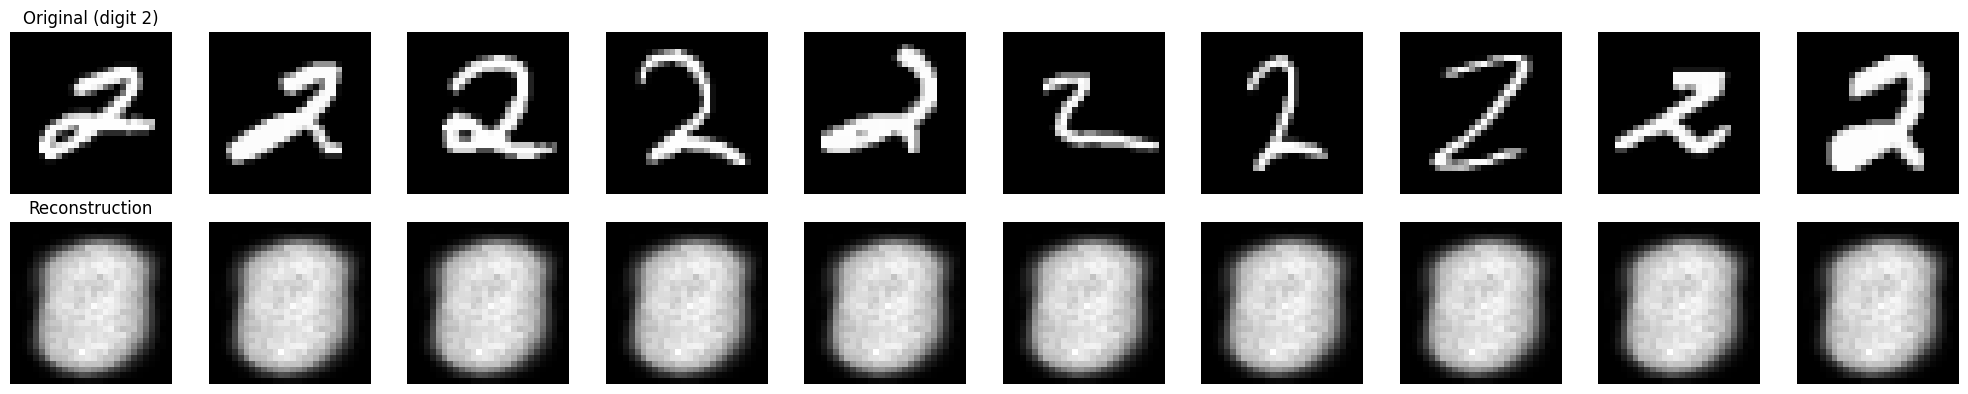

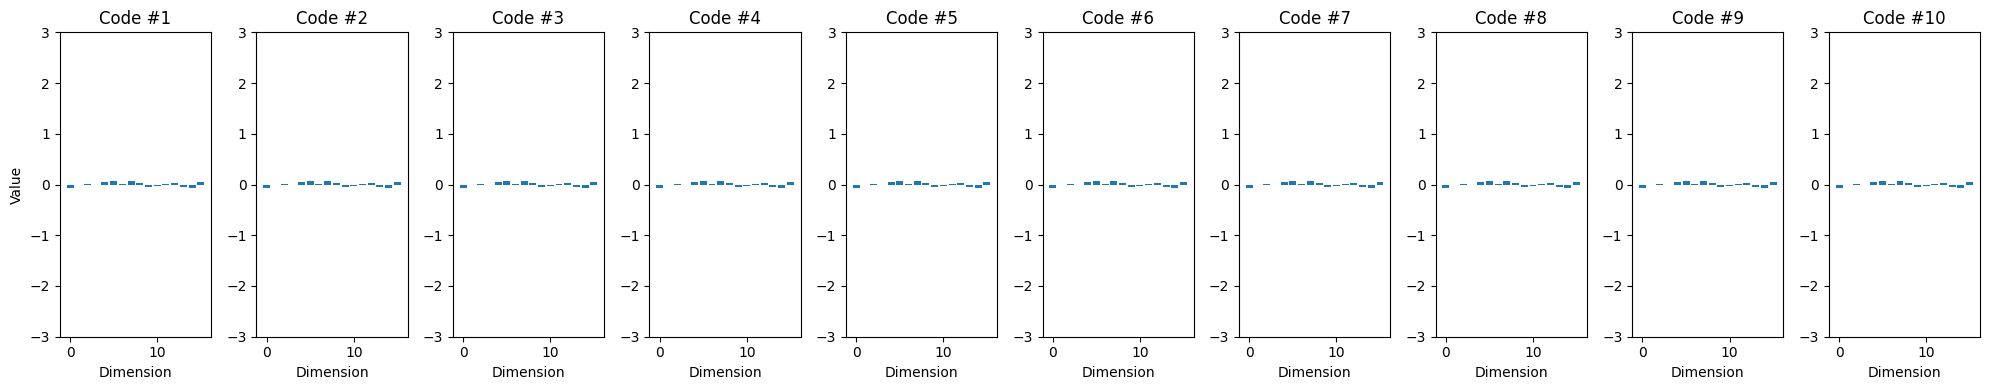

In [15]:
show_digit_reconstructions(y=2, X=X, y_labels= torch.tensor(y_train), model=model, device=device)

In [16]:
# import mnist

# # Chargement du test set
# _, (X_test, y_test) = mnist.load_data()
# X_test = X_test.reshape(-1, 784) / 255.0

# # Affichage des reconstructions sur le test set
# show_digit_reconstructions(y=2, X=X_test, model=model, device=device)

In [13]:
for digit in range(1, 10):
    mean_latent_digit = get_mean_latent_factors(digit=digit, X=X, y=y_train, model=model, device=device).tolist()
    print(digit, mean_latent_digit)

1 [0.08559343963861465, -0.0906493067741394, 0.08084503561258316, -0.015979701653122902, -0.09491217136383057, -0.07091878354549408, -0.07726980000734329, -0.0052794283255934715, -0.1262092888355255, -0.039369966834783554, 0.01943829469382763, -0.04176485165953636, -0.013934728689491749, -0.0866248607635498, 0.06867427378892899, 0.08967258036136627, 0.021296847611665726, 0.12505477666854858, 0.07280068099498749, -0.07378885895013809, -0.05574670061469078, -0.07569221407175064, -0.10154497623443604, -0.07242729514837265, -0.030405832454562187, -0.0649113655090332, -0.016558412462472916, 0.048388514667749405, -0.02718988247215748, 0.10540692508220673, 0.05870458483695984, -0.0016164741246029735]
2 [0.07616747915744781, -0.11298176646232605, 0.09479659050703049, -0.01660083793103695, -0.1638232320547104, -0.04931516572833061, -0.09656404703855515, -0.05618279054760933, -0.11861424893140793, -0.08392179757356644, 0.0252089686691761, -0.014618135057389736, -0.0007541237282566726, -0.1108245

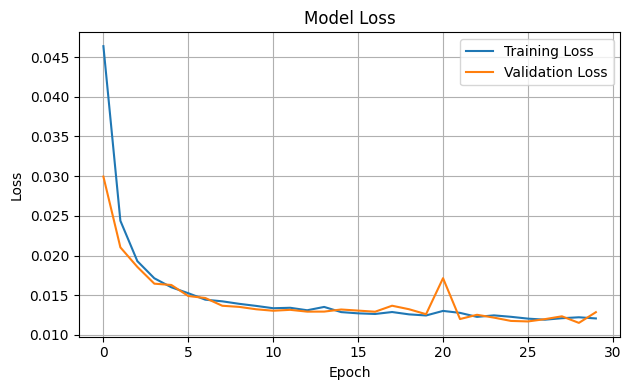

In [ ]:
plot_training_history(history)

# Autoencodeur MLP

In [102]:
from src.models.ae_mlp import MLPAutoencoder

mlp_ae = MLPAutoencoder(
    input_dim=784, 
    k=2, 
    hidden=(128, 80), 
    activation="relu", 
    use_bn=False, 
    dropout_p=0.0, 
    loss_type="mse"
    )

In [103]:
# Affichage de l'architecture du modèle
print("🏗️ Architecture de l'autoencodeur MLP:")
print("\nEncodeur:")
print(f"Input ({mlp_ae.input_dim}) → {' → '.join(map(str, mlp_ae.hidden))} → Latent ({mlp_ae.k})")
print("\nDécodeur:")
print(f"Latent ({mlp_ae.k}) → {' → '.join(map(str, mlp_ae.hidden[::-1]))} → Output ({mlp_ae.input_dim})")

# Nombre total de paramètres
total_params = sum(p.numel() for p in mlp_ae.parameters())
trainable_params = sum(p.numel() for p in mlp_ae.parameters() if p.requires_grad)
print(f"\n📊 Paramètres totaux: {total_params:,}")
print(f"📊 Paramètres entraînables: {trainable_params:,}")


🏗️ Architecture de l'autoencodeur MLP:

Encodeur:
Input (784) → 128 → 80 → Latent (2)

Décodeur:
Latent (2) → 80 → 128 → Output (784)

📊 Paramètres totaux: 222,706
📊 Paramètres entraînables: 222,706


In [104]:
# Entraînement du modèle MLP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_ae = mlp_ae.to(device)

# Déplacer X sur CPU avant l'entraînement comme requis par fit()
if X.device.type != "cpu":
    X = X.cpu()

print("🚀 Démarrage de l'entraînement...")
hist = mlp_ae.fit(
    X,
    epochs=100,
    batch_size=128,
    learning_rate=1e-3,
    patience=15,
    verbose=True,
    device=device
)

print("✅ Entraînement terminé!")


🚀 Démarrage de l'entraînement...


c:\Users\xtrem\Documents\Git\DimRed-KAN-Finance\src\models\ae_mlp.py:188: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.type == "cuda"))


🚀 ENTRAÎNEMENT MLP AUTOENCODER
📊 Data: 48000 train | 12000 val
🏗️  Arch: 784 -> 128 -> 80 -> 2 -> 80 -> 128 -> 784
⚙️  Params: epochs=100, bs=128, lr=0.001, loss=mse
🔧 Device: cuda | AMP: True
🔢 Paramètres: 222,706 total | 222,706 entraînables
----------------------------------------------------------------------------------------


c:\Users\xtrem\Documents\Git\DimRed-KAN-Finance\src\models\ae_mlp.py:220: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(amp and device.type == "cuda")):


📈 Époque   1/100 | Train: 0.054740 | Val: 0.047942 ⚠️ | LR: 1.00e-03 | ⏱️ 9.1s (ETA: 902.5s)
📈 Époque   2/100 | Train: 0.046462 | Val: 0.045741 ⚠️ | LR: 1.00e-03 | ⏱️ 12.1s (ETA: 593.4s)
📈 Époque   3/100 | Train: 0.044787 | Val: 0.044487 ⚠️ | LR: 1.00e-03 | ⏱️ 15.1s (ETA: 486.7s)
📈 Époque   4/100 | Train: 0.043871 | Val: 0.043886 ⚠️ | LR: 1.00e-03 | ⏱️ 18.2s (ETA: 437.4s)
📈 Époque   5/100 | Train: 0.043269 | Val: 0.043194 ⚠️ | LR: 1.00e-03 | ⏱️ 21.3s (ETA: 404.5s)
📈 Époque   6/100 | Train: 0.042739 | Val: 0.042982 ⚠️ | LR: 1.00e-03 | ⏱️ 24.4s (ETA: 381.8s)
📈 Époque   7/100 | Train: 0.042353 | Val: 0.042448 ⚠️ | LR: 1.00e-03 | ⏱️ 27.4s (ETA: 364.6s)
📈 Époque   8/100 | Train: 0.041995 | Val: 0.042258 ⚠️ | LR: 1.00e-03 | ⏱️ 30.4s (ETA: 349.6s)
📈 Époque   9/100 | Train: 0.041772 | Val: 0.041827 ⚠️ | LR: 1.00e-03 | ⏱️ 33.4s (ETA: 338.1s)
📈 Époque  10/100 | Train: 0.041511 | Val: 0.041652 ⚠️ | LR: 1.00e-03 | ⏱️ 36.6s (ETA: 329.1s)
📈 Époque  11/100 | Train: 0.041262 | Val: 0.041503 ⚠️ | LR: 1

In [18]:
show_digit_reconstructions(y=2, X=X, y_labels=torch.tensor(y_train), model=mlp_ae, device=device, n_samples=10)

NameError: name 'mlp_ae' is not defined

# Test set

In [6]:
y_test = test["label"]
X_test = test.drop("label", axis=1)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (10000, 784)
y_test shape: (10000,)


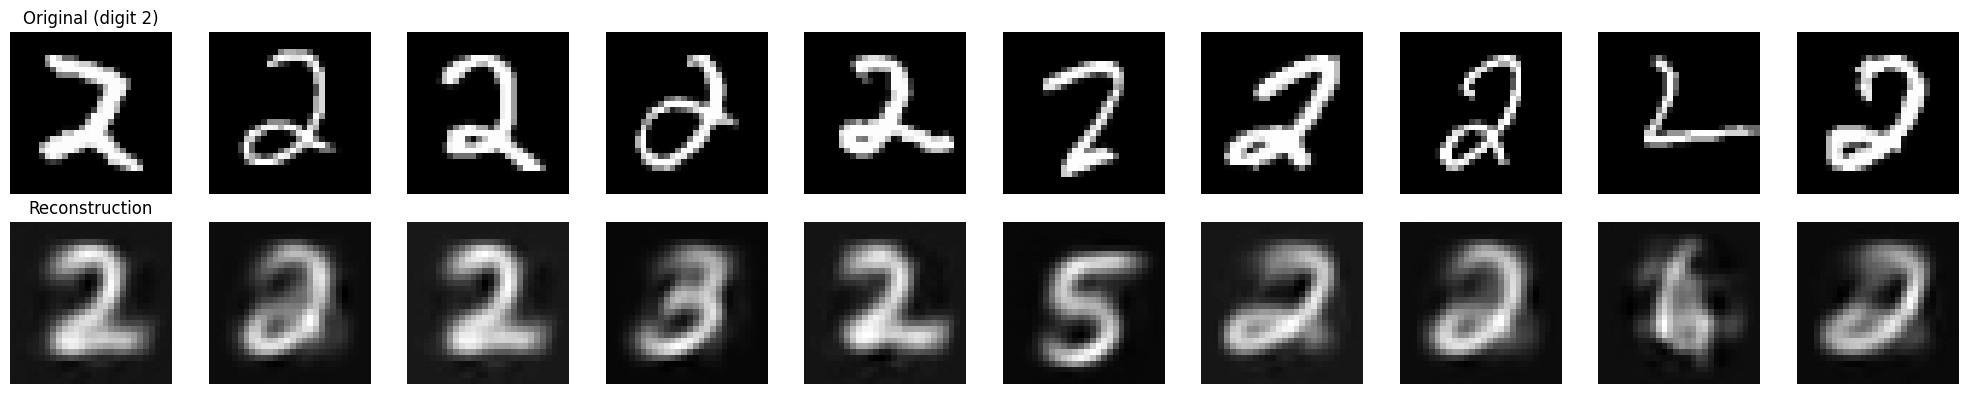

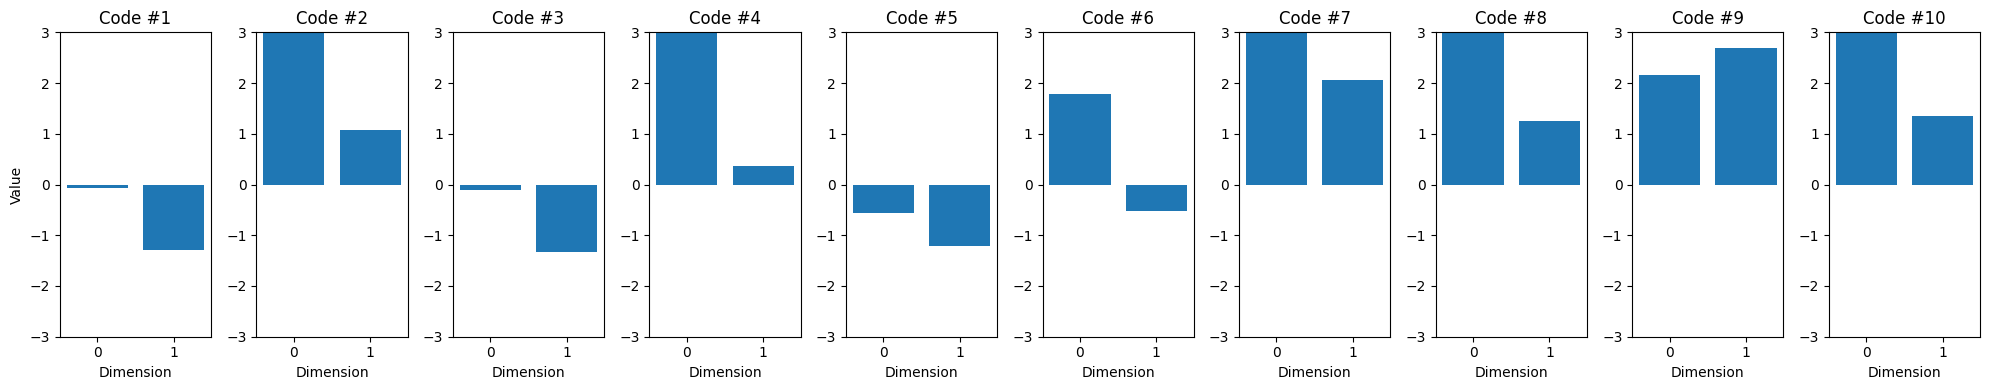

In [106]:
X_test_tensor = torch.FloatTensor(X_test.values) / 255.0
y_test_tensor = torch.tensor(y_test.values)


show_digit_reconstructions(y=2, X=X_test_tensor, y_labels=y_test_tensor, model=mlp_ae, device=device, n_samples=10)


In [107]:
# Obtenir les encodages du MLP AE
X_encoded = mlp_ae.encode(X.to(device)).cpu().detach().numpy()

# Calculer la variance expliquée
def explained_variance_ratio(X_original, X_encoded):
    # Calculer la variance totale des données originales
    total_variance = np.var(X_original.numpy(), axis=0).sum()
    
    # Calculer la variance résiduelle (erreur de reconstruction)
    X_reconstructed = mlp_ae.forward(X_original.to(device))[0].cpu().detach().numpy()
    residual_variance = np.var(X_original.numpy() - X_reconstructed, axis=0).sum()
    
    # Calculer le ratio de variance expliquée
    explained_var_ratio = 1 - (residual_variance / total_variance)
    return explained_var_ratio

variance_explained = explained_variance_ratio(X, X_encoded)
print(f"Variance expliquée par l'auto-encodeur: {variance_explained:.2%}")

# # Visualiser la reconstruction vs original pour quelques exemples
# plt.figure(figsize=(12, 4))
# n_examples = 5
# X_reconstructed = mlp_ae(X[:n_examples].to(device)).cpu().detach()

# for i in range(n_examples):
#     # Image originale
#     plt.subplot(2, n_examples, i+1)
#     plt.imshow(X[i].reshape(28, 28), cmap='gray')
#     plt.axis('off')
#     if i == 0:
#         plt.title('Original')
        
#     # Image reconstruite
#     plt.subplot(2, n_examples, i+1+n_examples)
#     plt.imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
#     plt.axis('off')
#     if i == 0:
#         plt.title('Reconstruction')

# plt.tight_layout()
# plt.show()


Variance expliquée par l'auto-encodeur: 45.19%


# PCA 

Variance expliquée par les 2 premières composantes: 16.80%


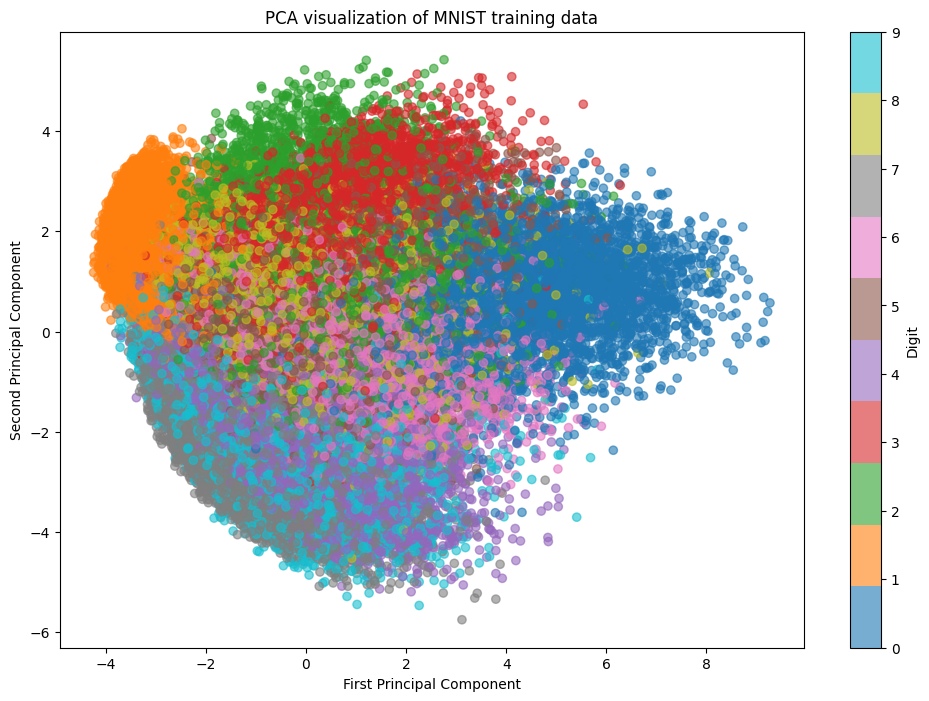

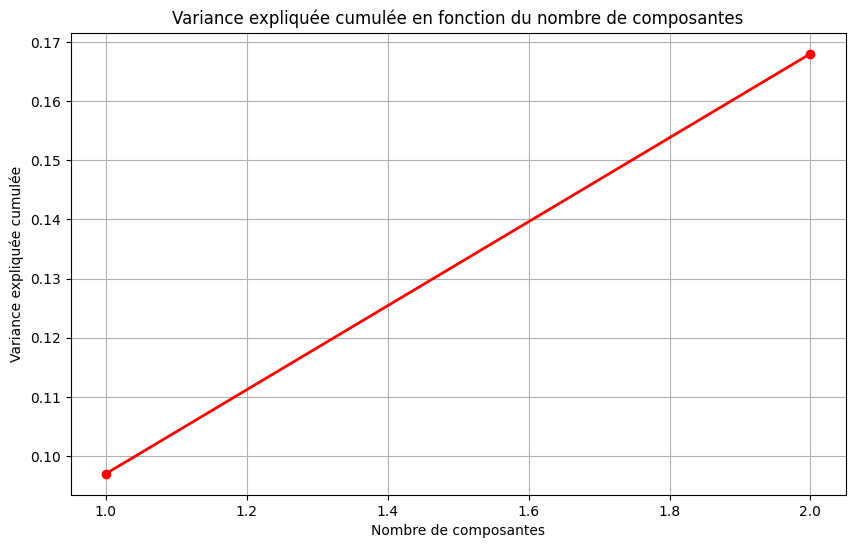

In [7]:
# Importation des bibliothèques nécessaires pour PCA
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Création et entraînement du PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.numpy())

# Création du scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Digit')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA visualization of MNIST training data')

# Affichage du pourcentage de variance expliquée
print(f"Variance expliquée par les 2 premières composantes: {pca.explained_variance_ratio_.sum():.2%}")

# Graphique de la variance expliquée cumulée
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
         np.cumsum(pca.explained_variance_ratio_), 
         'ro-', linewidth=2)
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance expliquée cumulée')
plt.title('Variance expliquée cumulée en fonction du nombre de composantes')
plt.grid(True)
plt.show()


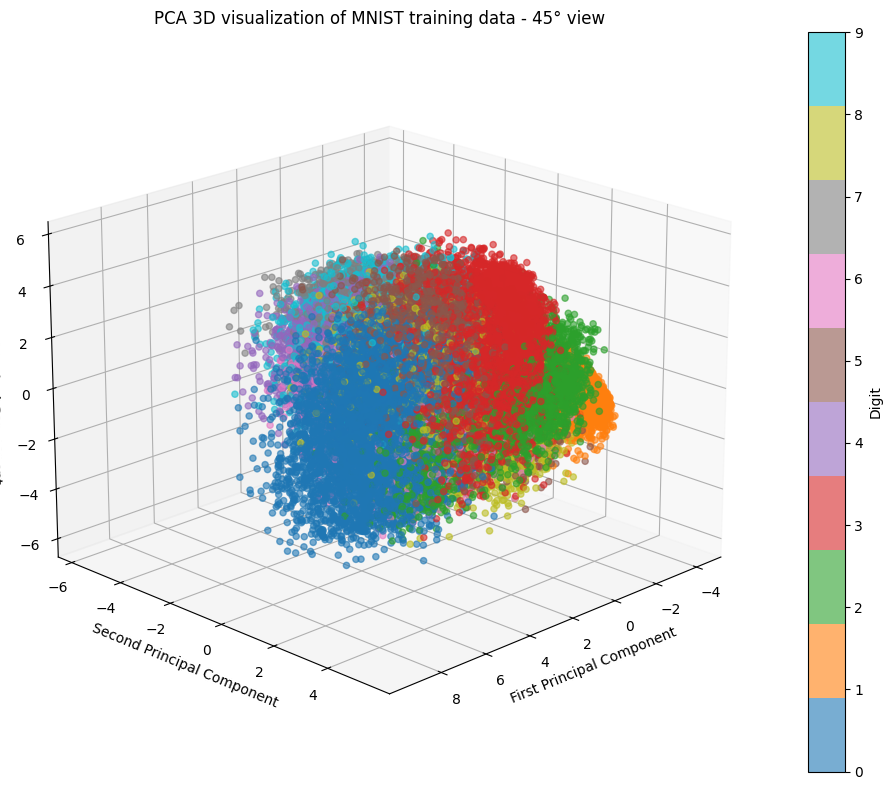

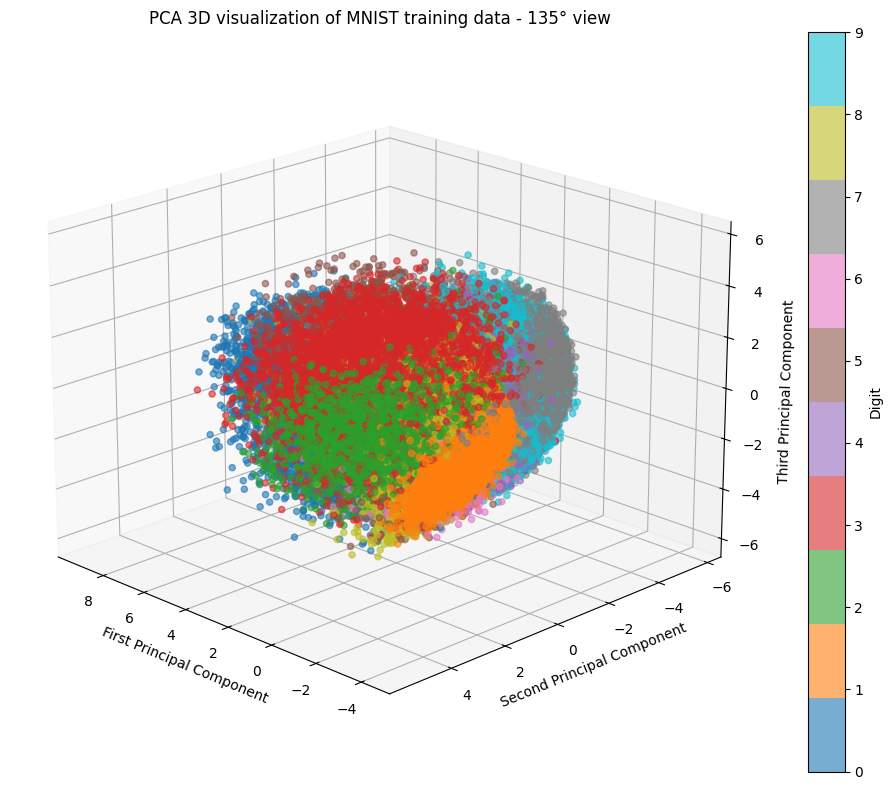

Variance explained by first 3 components: 22.97%


In [7]:
# Create and train PCA in 3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X.numpy())

# View 1 - Front view
fig1 = plt.figure(figsize=(12, 8))
ax1 = fig1.add_subplot(111, projection='3d')
scatter1 = ax1.scatter(X_pca_3d[:, 0], 
                      X_pca_3d[:, 1], 
                      X_pca_3d[:, 2],
                      c=y_train,
                      cmap='tab10', 
                      alpha=0.6)
ax1.view_init(elev=20, azim=45)
ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
ax1.set_zlabel('Third Principal Component')
ax1.set_title('PCA 3D visualization of MNIST training data - 45° view')
plt.colorbar(scatter1, label='Digit')
plt.tight_layout()
plt.show()

# View 2 - Side view
fig2 = plt.figure(figsize=(12, 8))
ax2 = fig2.add_subplot(111, projection='3d')
scatter2 = ax2.scatter(X_pca_3d[:, 0], 
                      X_pca_3d[:, 1], 
                      X_pca_3d[:, 2],
                      c=y_train,
                      cmap='tab10', 
                      alpha=0.6)
ax2.view_init(elev=20, azim=135)
ax2.set_xlabel('First Principal Component')
ax2.set_ylabel('Second Principal Component')
ax2.set_zlabel('Third Principal Component')
ax2.set_title('PCA 3D visualization of MNIST training data - 135° view')
plt.colorbar(scatter2, label='Digit')
plt.tight_layout()
plt.show()

# Display explained variance ratio for 3 components
print(f"Variance explained by first 3 components: {pca_3d.explained_variance_ratio_.sum():.2%}")

In [8]:
# Analyze variance explained vs number of components for PCA and MLP AE
import numpy as np
from sklearn.decomposition import PCA

# Define range of components to test
n_components_range = range(2, 11)
pca_variance_explained = []
mlp_ae_variance_explained = []

print("Training models for different numbers of components...")

# Test PCA for different numbers of components
for n_comp in n_components_range:
    print(f"Training PCA with {n_comp} components...")
    pca = PCA(n_components=n_comp)
    pca.fit(X.numpy())
    pca_variance_explained.append(pca.explained_variance_ratio_.sum())


Training models for different numbers of components...
Training PCA with 2 components...
Training PCA with 3 components...
Training PCA with 4 components...
Training PCA with 5 components...
Training PCA with 6 components...
Training PCA with 7 components...
Training PCA with 8 components...
Training PCA with 9 components...
Training PCA with 10 components...


In [18]:

if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("GPU memory cleared")


GPU memory cleared


In [9]:
from src.models.ae_mlp import MLPAutoencoder

# Test MLP AE for different numbers of components
for n_comp in n_components_range:
    print(f"Training MLP AE with {n_comp} latent dimensions...")
    
    # Create and train MLP AE with current number of components
    mlp_ae = MLPAutoencoder(
        input_dim=784,
        hidden=[256, 128],
        k=n_comp,
        dropout_p=0.05
    )
    
    # Train the autoencoder using the proper method and keep history
    hist = mlp_ae.fit(
        X=X,
        epochs=80,
        batch_size=128,
        learning_rate=0.001,
        patience=15,
        verbose=True,
        device=device
    )
    
    
    # Calculate variance explained by reconstruction
    with torch.no_grad():
        mlp_ae.eval()
        X_reconstructed = mlp_ae(X.to(device))
        
        X_reconstructed_cpu, X_reconstructed_latent = X_reconstructed[0].cpu(), X_reconstructed[1].cpu()
        
        total_variance = torch.var(X, dim=0).sum()
        reconstruction_error = torch.mean((X - X_reconstructed_cpu) ** 2, dim=0).sum()
        variance_explained = 1 - (reconstruction_error / total_variance)
        mlp_ae_variance_explained.append(variance_explained.item())


Training MLP AE with 2 latent dimensions...


c:\Users\xtrem\Documents\Git\DimRed-KAN-Finance\src\models\ae_mlp.py:188: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(amp and device.type == "cuda"))


🚀 ENTRAÎNEMENT MLP AUTOENCODER
📊 Data: 48000 train | 12000 val
🏗️  Arch: 784 -> 256 -> 128 -> 2 -> 128 -> 256 -> 784
⚙️  Params: epochs=80, bs=128, lr=0.001, loss=mse
🔧 Device: cuda | AMP: True
🔢 Paramètres: 469,010 total | 469,010 entraînables
----------------------------------------------------------------------------------------


c:\Users\xtrem\Documents\Git\DimRed-KAN-Finance\src\models\ae_mlp.py:220: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(amp and device.type == "cuda")):


📈 Époque   1/80 | Train: 0.054443 | Val: 0.048388 ⚠️ | LR: 1.00e-03 | ⏱️ 9.1s (ETA: 719.1s)
📈 Époque   2/80 | Train: 0.048405 | Val: 0.046398 ⚠️ | LR: 1.00e-03 | ⏱️ 13.6s (ETA: 529.3s)
📈 Époque   3/80 | Train: 0.046993 | Val: 0.045191 ⚠️ | LR: 1.00e-03 | ⏱️ 18.1s (ETA: 464.2s)
📈 Époque   4/80 | Train: 0.046056 | Val: 0.044776 ⚠️ | LR: 1.00e-03 | ⏱️ 22.8s (ETA: 432.7s)
📈 Époque   5/80 | Train: 0.045367 | Val: 0.043737 ⚠️ | LR: 1.00e-03 | ⏱️ 26.8s (ETA: 401.7s)
📈 Époque   6/80 | Train: 0.044812 | Val: 0.043381 ⚠️ | LR: 1.00e-03 | ⏱️ 30.8s (ETA: 380.1s)
📈 Époque   7/80 | Train: 0.044402 | Val: 0.042793 ⚠️ | LR: 1.00e-03 | ⏱️ 35.0s (ETA: 365.0s)
📈 Époque   8/80 | Train: 0.044202 | Val: 0.043018 ⚠️ | LR: 1.00e-03 | ⏱️ 39.0s (ETA: 350.8s)
📈 Époque   9/80 | Train: 0.043964 | Val: 0.042497 ⚠️ | LR: 1.00e-03 | ⏱️ 43.2s (ETA: 341.0s)
📈 Époque  10/80 | Train: 0.043734 | Val: 0.042376 ⚠️ | LR: 1.00e-03 | ⏱️ 47.3s (ETA: 331.2s)
📈 Époque  11/80 | Train: 0.043633 | Val: 0.042368 ⚠️ | LR: 1.00e-03 | ⏱

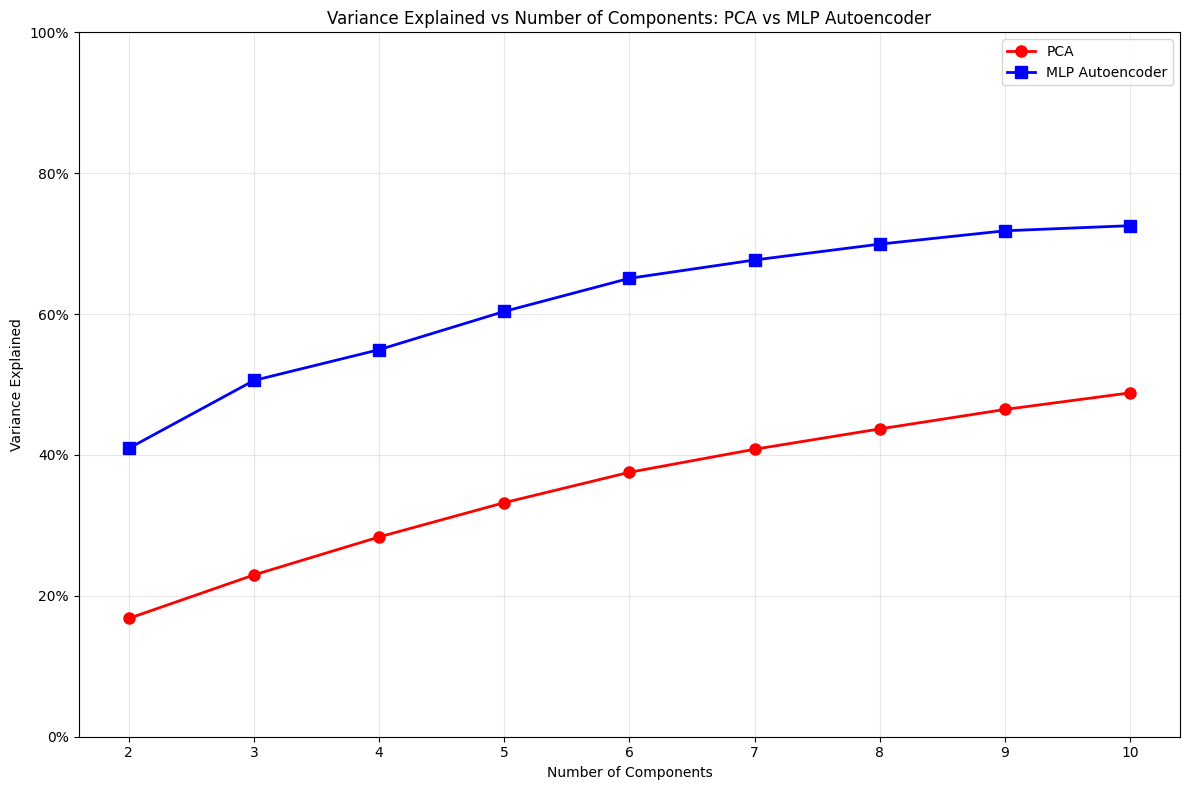


Variance Explained Summary:
Components | PCA     | MLP AE
-----------|---------|-------
        2 | 16.80% | 40.95%
        3 | 22.97% | 50.58%
        4 | 28.36% | 54.95%
        5 | 33.23% | 60.38%
        6 | 37.54% | 65.08%
        7 | 40.81% | 67.68%
        8 | 43.70% | 69.93%
        9 | 46.46% | 71.82%
       10 | 48.81% | 72.55%


In [11]:
# Create comparison plot
plt.figure(figsize=(12, 8))
plt.plot(n_components_range, pca_variance_explained, 'o-', color='red', linewidth=2, markersize=8, label='PCA')
plt.plot(n_components_range, mlp_ae_variance_explained, 's-', color='blue', linewidth=2, markersize=8, label='MLP Autoencoder')

plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.title('Variance Explained vs Number of Components: PCA vs MLP Autoencoder')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(n_components_range)
plt.ylim(0, 1)

# Add percentage labels on y-axis
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

# Print summary
print("\nVariance Explained Summary:")
print("Components | PCA     | MLP AE")
print("-----------|---------|-------")
for i, n_comp in enumerate(n_components_range):
    print(f"{n_comp:9d} | {pca_variance_explained[i]:6.2%} | {mlp_ae_variance_explained[i]:6.2%}")
